In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import cross_val_score
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler

### Cargo los archivos

* Previamente los genere con las notebook subidas
* Los avisos tienen 250 columnas con las matrices 'UxE' de la salida de aplicar SVD,
    pero por ahora no las uso.
* Las vistas contienen la cantidad de vistas

In [2]:
post = pd.read_csv('/home/pcsor/facu/TP2/postulaciones.csv',low_memory=False)
avisos = pd.read_csv('/home/pcsor/facu/TP2/avisos3.csv',low_memory=False)
postulantes = pd.read_csv('/home/pcsor/facu/TP2/postulantes.csv',low_memory=False)
test = pd.read_csv('/home/pcsor/facu/TP2/test_final_100k.csv',low_memory=False)
cantidadVistas = pd.read_csv('/home/pcsor/facu/TP2/cantidadVistas.csv',low_memory=False)
cantidadVistas15 = pd.read_csv('/home/pcsor/facu/TP2/cantidadVistas15.csv',low_memory=False)
cantidadVistasTest = pd.read_csv('/home/pcsor/facu/TP2/cantidadVistasTest.csv',low_memory=False)
cantidadVistasTotalesPorAviso = pd.read_csv('/home/pcsor/facu/TP2/cantidadVistasTotalesPorAviso.csv',low_memory=False)
cantidadVistasPorAviso15 = pd.read_csv('/home/pcsor/facu/TP2/cantidadVistasPorAviso15.csv',low_memory=False)
cantidadVistasPorAvisoTest = pd.read_csv('/home/pcsor/facu/TP2/cantidadVistasPorAvisoTest.csv',low_memory=False)
cantidadVistasTotalesPorPostulante = pd.read_csv('/home/pcsor/facu/TP2/cantidadVistasTotalesPorPostulante.csv',low_memory=False)
cantidadVistasPorPostulante15 = pd.read_csv('/home/pcsor/facu/TP2/cantidadVistasPorPostulante15.csv',low_memory=False)
cantidadVistasPorPostulanteTest = pd.read_csv('/home/pcsor/facu/TP2/cantidadVistasPorPostulanteTest.csv',low_memory=False)
cantidadPostulaciones10 = pd.read_csv('/home/pcsor/facu/TP2/cantidadPostulaciones10.csv',low_memory=False)
cantidadPostulaciones4 = pd.read_csv('/home/pcsor/facu/TP2/cantidadPostulaciones4.csv',low_memory=False)
cantidadPostulacionesAviso4 =  pd.read_csv('/home/pcsor/facu/TP2/cantidadPostulacionesAviso4.csv',low_memory=False)
cantidadPostulacionesAviso10 = pd.read_csv('/home/pcsor/facu/TP2/cantidadPostulacionesAviso10.csv',low_memory=False)
cantidadPostulaciones = pd.read_csv('/home/pcsor/facu/TP2/cantidadPostulaciones.csv',low_memory=False)

In [3]:
avisos[0:2]

,idaviso,nombre_zona,tipo_de_trabajo,nombre_area,0,1,2,3,4,5,...,21,22,23,24,25,26,27,28,29,nivel_laboral
0,1001284385,2,1,137,-5.467577e-15,-8.451362e-14,-8.197287e-14,2.939901e-13,-1.154531e-12,-4.924603e-13,...,5.101614e-12,9.380850e-12,-1.135179e-11,-8.559552e-12,-5.632658e-12,-2.378366e-13,1.347250e-11,1.548645e-11,2.647626e-11,NaN
1,1110092955,1,1,143,7.534270e-03,4.948141e-03,2.774831e-02,-8.603403e-03,-5.308518e-02,-6.630085e-03,...,-5.366094e-03,-1.340431e-02,-1.844706e-02,1.028691e-01,-8.485015e-02,6.152027e-02,-8.554677e-02,-2.842450e-02,1.311970e-02,NaN


In [4]:
###### Drop a las columnas que no se utilizan
features = list(set(avisos.columns) - set(['idaviso','tipo_de_trabajo','nombre_area']))
avisos = avisos.drop(features,axis=1)

In [5]:
post['sepostulo'] = 1
test['sepostulo'] = 2

In [6]:
test.shape,test.columns

((100000, 4),
 Index(['id', 'idaviso', 'idpostulante', 'sepostulo'], dtype='object'))

In [7]:
post = post.loc[post['fechapostulacion'] > '2018-03-01 00:00:00']

In [8]:
##### Se arma un Trainset con dummys
train = pd.DataFrame()
train['idaviso'] = shuffle(post['idaviso'][0:3000000]).reset_index()['idaviso']
train['idpostulante'] = shuffle(post['idpostulante'][0:3000000]).reset_index()['idpostulante']
train['sepostulo'] = 0

In [9]:
##### Se controla que los dummys con '0' NO sean postulaciones reales
train = pd.merge(train, post, how='left', on=['idpostulante', 'idaviso'], indicator=True)
train = train.query('_merge != "both"')
train = train.drop(['_merge','sepostulo_y','fechapostulacion'],axis=1)
train.columns = ['idaviso','idpostulante','sepostulo']

In [10]:
##### Se controla que los dummys NO esten en las postulaciones a predecir
train = pd.merge(train, test, how='left', on=['idpostulante', 'idaviso'], indicator=True)
train = train.query('_merge != "both"')
train = train.drop(['_merge','id','sepostulo_y'],axis=1)
train.columns = ['idaviso','idpostulante','sepostulo']

In [11]:
train.columns,train.shape

(Index(['idaviso', 'idpostulante', 'sepostulo'], dtype='object'), (2918279, 3))

In [12]:
train = train.drop_duplicates(['idaviso','idpostulante'])

In [13]:
train.shape,post.shape

((2880456, 3), (3047350, 4))

In [14]:
###### Se filtran las postulaciones antiguas
post = post.sort_values(by='fechapostulacion',ascending=False)
post = post.reset_index().drop('index',axis=1)
abril = '2018-04-01 00:00:00'
post = post.loc[post['fechapostulacion']>abril]
post = post.drop(['fechapostulacion'], axis=1)
post[0:3]

,idaviso,idpostulante,sepostulo
0,1112470106,W9keddN,1
1,1112454333,ZDr9NB1,1
2,1112467020,bOjXla0,1


In [15]:
####### Se juntan los dummys con las postulaciones filtradas
train = pd.concat([train,post])
train = shuffle(train)
train = train.reset_index().drop('index',axis=1)
train = train.drop_duplicates(['idaviso','idpostulante'])

In [16]:
train = pd.concat([train,test])

In [17]:
####### Se agregan los features de los avisos
train = pd.merge(train,avisos,how='left',on='idaviso',indicator=True)
train = train.query('_merge != "left_only"')
train = train.drop(['_merge'],axis=1)
train[0:3]

,id,idaviso,idpostulante,sepostulo,tipo_de_trabajo,nombre_area
0,NaN,1112393364,96zQXop,0,1.0,181.0
1,NaN,1112435842,KBdMYM0,1,1.0,116.0
2,NaN,1112414920,A3X0LEL,0,1.0,22.0


In [18]:
####### Agrego la cantidad de vistas y relleno con '0' las que no son vistas
train = pd.merge(train,cantidadVistas,how='left',on=['idaviso','idpostulante',])
train['cantidadDeVistas'] = train['cantidadDeVistas'].fillna(0)

In [19]:
train = pd.merge(train,cantidadVistasTotalesPorAviso,how='left',on=['idaviso'])
train['vistasPorAvisoTotales'] = train['vistasPorAvisoTotales'].fillna(0)

In [20]:
train = pd.merge(train,cantidadVistasTotalesPorPostulante,how='left',on=['idpostulante'])
train['vistasPorPostulanteTotales'] = train['vistasPorPostulanteTotales'].fillna(0)

In [21]:
train['vistasPorPostulanteTotales'].mean(),train['vistasPorAvisoTotales'].mean(),train['cantidadDeVistas'].mean()

(131.47438705269167, 3973.2272914776813, 0.481168524586318)

In [22]:
train[0:4]

,id,idaviso,idpostulante,sepostulo,tipo_de_trabajo,nombre_area,cantidadDeVistas,vistasPorAvisoTotales,vistasPorPostulanteTotales
0,NaN,1112393364,96zQXop,0,1.0,181.0,0.0,880.0,30.0
1,NaN,1112435842,KBdMYM0,1,1.0,116.0,1.0,685.0,46.0
2,NaN,1112414920,A3X0LEL,0,1.0,22.0,0.0,1384.0,14.0
3,NaN,1112365193,2zw1jqa,0,1.0,30.0,0.0,947.0,157.0


In [23]:
####### Agrego los datos de los postulantes y se rellenan los NaNs con el promedio
train = pd.merge(train,postulantes,how='left',on=['idpostulante'])
train['edad'] = train['edad'].fillna(int(train['edad'].mean()))
train['nombre'] = train['nombre'].fillna(int(train['nombre'].mean()))
train = train.drop('estado',axis = 1)

In [24]:
####### Agrego la cantidad de postulaciones y relleno con '0' 
train = pd.merge(train,cantidadPostulaciones10,how='left',on=['idpostulante'])
train['cantidadPostulaciones10'] = train['cantidadPostulaciones10'].fillna(0)
train = pd.merge(train,cantidadPostulaciones4,how='left',on=['idpostulante'])
train['cantidadPostulaciones4'] = train['cantidadPostulaciones4'].fillna(0)
train = pd.merge(train,cantidadPostulaciones,how='left',on=['idpostulante'])
train['cantidadPostulaciones'] = train['cantidadPostulaciones'].fillna(0)
train = pd.merge(train,cantidadPostulacionesAviso4,how='left',on=['idaviso'])
train['cantidadPostulacionesAviso4'] = train['cantidadPostulacionesAviso4'].fillna(0)
train = pd.merge(train,cantidadPostulacionesAviso10,how='left',on=['idaviso'])
train['cantidadPostulacionesAviso10'] = train['cantidadPostulacionesAviso10'].fillna(0)

### Normalizando los features numericos

In [25]:
x = train.iloc[:,4:].values 
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)
df.columns = train.iloc[:,4:].keys()
train = pd.concat([train.drop(train.iloc[:,4:].keys(),axis=1),df],axis=1)

In [26]:
test = train.loc[train['sepostulo']==2]

In [27]:
test.shape,test.columns

((100000, 17),
 Index(['id', 'idaviso', 'idpostulante', 'sepostulo', 'tipo_de_trabajo',
        'nombre_area', 'cantidadDeVistas', 'vistasPorAvisoTotales',
        'vistasPorPostulanteTotales', 'sexo', 'edad', 'nombre',
        'cantidadPostulaciones10', 'cantidadPostulaciones4',
        'cantidadPostulaciones', 'cantidadPostulacionesAviso4',
        'cantidadPostulacionesAviso10'],
       dtype='object'))

In [28]:
test = test.drop('sepostulo',axis=1)
train = train.drop('id',axis=1)

In [29]:
train = train.loc[train['sepostulo'] != 2]

In [30]:
test.shape,test.columns,train.shape,train.columns

((100000, 16),
 Index(['id', 'idaviso', 'idpostulante', 'tipo_de_trabajo', 'nombre_area',
        'cantidadDeVistas', 'vistasPorAvisoTotales',
        'vistasPorPostulanteTotales', 'sexo', 'edad', 'nombre',
        'cantidadPostulaciones10', 'cantidadPostulaciones4',
        'cantidadPostulaciones', 'cantidadPostulacionesAviso4',
        'cantidadPostulacionesAviso10'],
       dtype='object'),
 (3992032, 16),
 Index(['idaviso', 'idpostulante', 'sepostulo', 'tipo_de_trabajo',
        'nombre_area', 'cantidadDeVistas', 'vistasPorAvisoTotales',
        'vistasPorPostulanteTotales', 'sexo', 'edad', 'nombre',
        'cantidadPostulaciones10', 'cantidadPostulaciones4',
        'cantidadPostulaciones', 'cantidadPostulacionesAviso4',
        'cantidadPostulacionesAviso10'],
       dtype='object'))

In [31]:
####### Agrego la cantidad de vistas y relleno con '0' las que no son vistas
train = pd.merge(train,cantidadVistas15,how='left',on=['idaviso','idpostulante',])
train['cantidadDeVistas15'] = train['cantidadDeVistas15'].fillna(0)
train = pd.merge(train,cantidadVistasPorAviso15,how='left',on=['idaviso'])
train['vistasPorAviso15'] = train['vistasPorAviso15'].fillna(0)
train = pd.merge(train,cantidadVistasPorPostulante15,how='left',on=['idpostulante',])
train['vistasPorPostulante15'] = train['vistasPorPostulante15'].fillna(0)

In [32]:
train.columns

Index(['idaviso', 'idpostulante', 'sepostulo', 'tipo_de_trabajo',
       'nombre_area', 'cantidadDeVistas', 'vistasPorAvisoTotales',
       'vistasPorPostulanteTotales', 'sexo', 'edad', 'nombre',
       'cantidadPostulaciones10', 'cantidadPostulaciones4',
       'cantidadPostulaciones', 'cantidadPostulacionesAviso4',
       'cantidadPostulacionesAviso10', 'cantidadDeVistas15',
       'vistasPorAviso15', 'vistasPorPostulante15'],
      dtype='object')

In [33]:
x = train[['cantidadDeVistas15','vistasPorAviso15','vistasPorPostulante15']].values
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)
df.columns = train[['cantidadDeVistas15','vistasPorAviso15','vistasPorPostulante15']].keys()
train = pd.concat([train[train.columns.difference(['cantidadDeVistas15','vistasPorAviso15','vistasPorPostulante15'])],df],axis=1)

In [34]:
####### Agrego la cantidad de vistas y relleno con '0' las que no son vistas
test = pd.merge(test,cantidadVistasTest,how='left',on=['idaviso','idpostulante',])
test['cantidadDeVistas15'] = test['cantidadDeVistas15'].fillna(0)
test = pd.merge(test,cantidadVistasPorAvisoTest,how='left',on=['idaviso'])
test['vistasPorAviso15'] = test['vistasPorAviso15'].fillna(0)
test = pd.merge(test,cantidadVistasPorPostulanteTest,how='left',on=['idpostulante',])
test['vistasPorPostulante15'] = test['vistasPorPostulante15'].fillna(0)

In [35]:
x = test[['cantidadDeVistas15','vistasPorAviso15','vistasPorPostulante15']].values
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)
df.columns = test[['cantidadDeVistas15','vistasPorAviso15','vistasPorPostulante15']].keys()
test = pd.concat([test[test.columns.difference(['cantidadDeVistas15','vistasPorAviso15','vistasPorPostulante15'])],df],axis=1)

In [41]:
#testid = test['id']
#train_y = train['sepostulo']
test = test.drop(['idaviso','idpostulante', 'nombre_area','tipo_de_trabajo','sexo'],axis=1)
train = train.drop(['idaviso','idpostulante', 'nombre_area','tipo_de_trabajo','sexo'],axis=1)

In [37]:
test = test.drop(['id'],axis=1)
train = train.drop(['sepostulo'],axis = 1)

In [53]:
train.dtypes

cantidadDeVistas                float64
cantidadPostulaciones           float64
cantidadPostulaciones10         float64
cantidadPostulaciones4          float64
cantidadPostulacionesAviso10    float64
cantidadPostulacionesAviso4     float64
edad                            float64
nombre                          float64
vistasPorAvisoTotales           float64
vistasPorPostulanteTotales      float64
cantidadDeVistas15              float64
vistasPorAviso15                float64
vistasPorPostulante15           float64
dtype: object

#### XGBOOST

In [64]:
xgb1 = xgb.XGBClassifier(eval_metric='auc',n_jobs=-1,silent=False,learning_rate=0.05,n_estimators=150)

In [65]:
xgb1.fit(train,train_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='auc', gamma=0, learning_rate=0.05,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=150, n_jobs=-1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=False,
       subsample=1)

<BarContainer object of 13 artists>

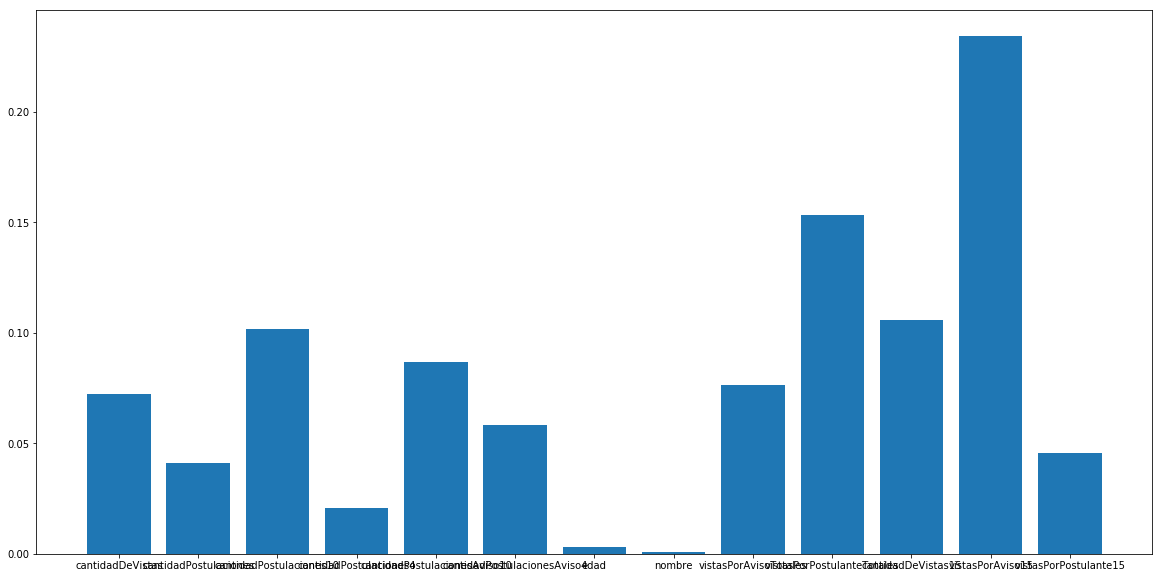

In [66]:
plt.figure(figsize=(20,10))
plt.bar(train.columns.values,xgb1.feature_importances_)

In [67]:
predic = xgb1.predict(test) 
predic.mean()

/home/pcsor/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.35347

In [68]:
submit = pd.DataFrame()
submit['id'] = testid
submit['sepostulo'] = predic
submit['id'] = submit['id'].apply(int)
submit.to_csv('/home/pcsor/facu/TP2/submit1.csv',index=False)